# Task description
```
mask, digits = predict_image(img)

# example
digits = [
    np.array([[-1, -1, -1, -1, -1, -1, -1, -1, -1],
              [-1, -1, -1,  8,  9,  4, -1, -1, -1],
              [-1, -1, -1,  6, -1,  1, -1, -1, -1],
              [-1,  6,  5,  1, -1,  9,  7,  8, -1],
              [-1,  1, -1, -1, -1, -1, -1,  3, -1],
              [-1,  3,  9,  4, -1,  5,  6,  1, -1],
              [-1, -1, -1,  8, -1,  2, -1, -1, -1],
              [-1, -1, -1,  9,  1,  3, -1, -1, -1],
              [-1, -1, -1, -1, -1, -1, -1, -1, -1]]),
]
```


## What should we take into account
- folded pages
- some cells of the puzzle may be hidden
- May be the case when to edges are not in the image
- more than 1 puzzle in image
- some cells of sudoku can be gray-colored

In [4]:
import joblib
from pathlib import Path
import glob

import numpy as np
from numpy import logical_and as land
from numpy import logical_not as lnot
from skimage.feature import canny
from skimage.transform import rescale, ProjectiveTransform, warp
from skimage.morphology import dilation, disk
import cv2 as cv
import matplotlib.pyplot as plt

from imutils.perspective import four_point_transform
from skimage.segmentation import clear_border
import imutils

## Global variables and functions

In [10]:
PROJ_PATH = Path('/home/dendenmushi/projects/Intro2CV_course/Homework_2')
IMAGES_PATH = PROJ_PATH/'images'
TRAIN_PATH = PROJ_PATH/'train'
TRAIN_IMG_NAMES = glob.glob(str(TRAIN_PATH/'*.jpg'))

SCALE = 0.33

# Find puzzle boundaries

In [11]:
def find_puzzle( image: np.ndarray, debug: bool = False ):
    
	gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
	blurred = cv.GaussianBlur(gray, (7, 7), 3)
	thresh = cv.adaptiveThreshold(blurred, 255,
		cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 11, 2)
	thresh = cv.bitwise_not(thresh)

	if debug:
		cv.imshow("Puzzle Thresh", thresh)
		cv.waitKey(0)

	cnts = cv.findContours(thresh.copy(), cv.RETR_EXTERNAL,
		cv.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)
	cnts = sorted(cnts, key=cv.contourArea, reverse=True)
	puzzleCnt = None
	for c in cnts:
		peri = cv.arcLength(c, True)
		approx = cv.approxPolyDP(c, 0.02 * peri, True)
		if len(approx) == 4:
			puzzleCnt = approx
			break
	if puzzleCnt is None:
		raise Exception(("Could not find Sudoku puzzle outline. "
			"Try debugging your thresholding and contour steps."))
	if debug:
		# draw the contour of the puzzle on the image and then display
		# it to our screen for visualization/debugging purposes
		output = image.copy()
		cv.drawContours(output, [puzzleCnt], -1, (0, 255, 0), 2)
		cv.imshow("Puzzle Outline", output)
		cv.waitKey(0)
    # apply a four point perspective transform to both the original
	# image and grayscale image to obtain a top-down bird's eye view
	# of the puzzle
	puzzle = four_point_transform(image, puzzleCnt.reshape(4, 2))
	warped = four_point_transform(gray, puzzleCnt.reshape(4, 2))
	# check to see if we are visualizing the perspective transform
	if debug:
		# show the output warped image (again, for debugging purposes)
		cv.imshow("Puzzle Transform", puzzle)
		cv.waitKey(0)
	# return a 2-tuple of puzzle in both RGB and grayscale
	return (puzzle, warped)

In [12]:
PROJ_PATH / 'amogus'

PosixPath('/home/dendenmushi/projects/Intro2CV_course/Homework_2/amogus')

In [13]:
TRAIN_IMG_NAMES

['/home/dendenmushi/projects/Intro2CV_course/Homework_2/train/train_6.jpg',
 '/home/dendenmushi/projects/Intro2CV_course/Homework_2/train/train_8.jpg',
 '/home/dendenmushi/projects/Intro2CV_course/Homework_2/train/train_3.jpg',
 '/home/dendenmushi/projects/Intro2CV_course/Homework_2/train/train_7.jpg',
 '/home/dendenmushi/projects/Intro2CV_course/Homework_2/train/train_2.jpg',
 '/home/dendenmushi/projects/Intro2CV_course/Homework_2/train/train_5.jpg',
 '/home/dendenmushi/projects/Intro2CV_course/Homework_2/train/train_0.jpg',
 '/home/dendenmushi/projects/Intro2CV_course/Homework_2/train/train_1.jpg',
 '/home/dendenmushi/projects/Intro2CV_course/Homework_2/train/train_4.jpg']

In [14]:
img = cv.imread(str(TRAIN_IMG_NAMES[0]))

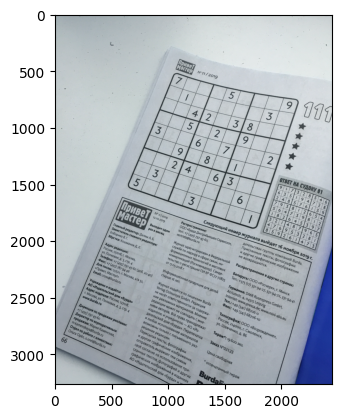

In [15]:
fig, ax = plt.subplots()

ax.imshow(img);

In [16]:
puzzle, warped = find_puzzle(img, debug=True)

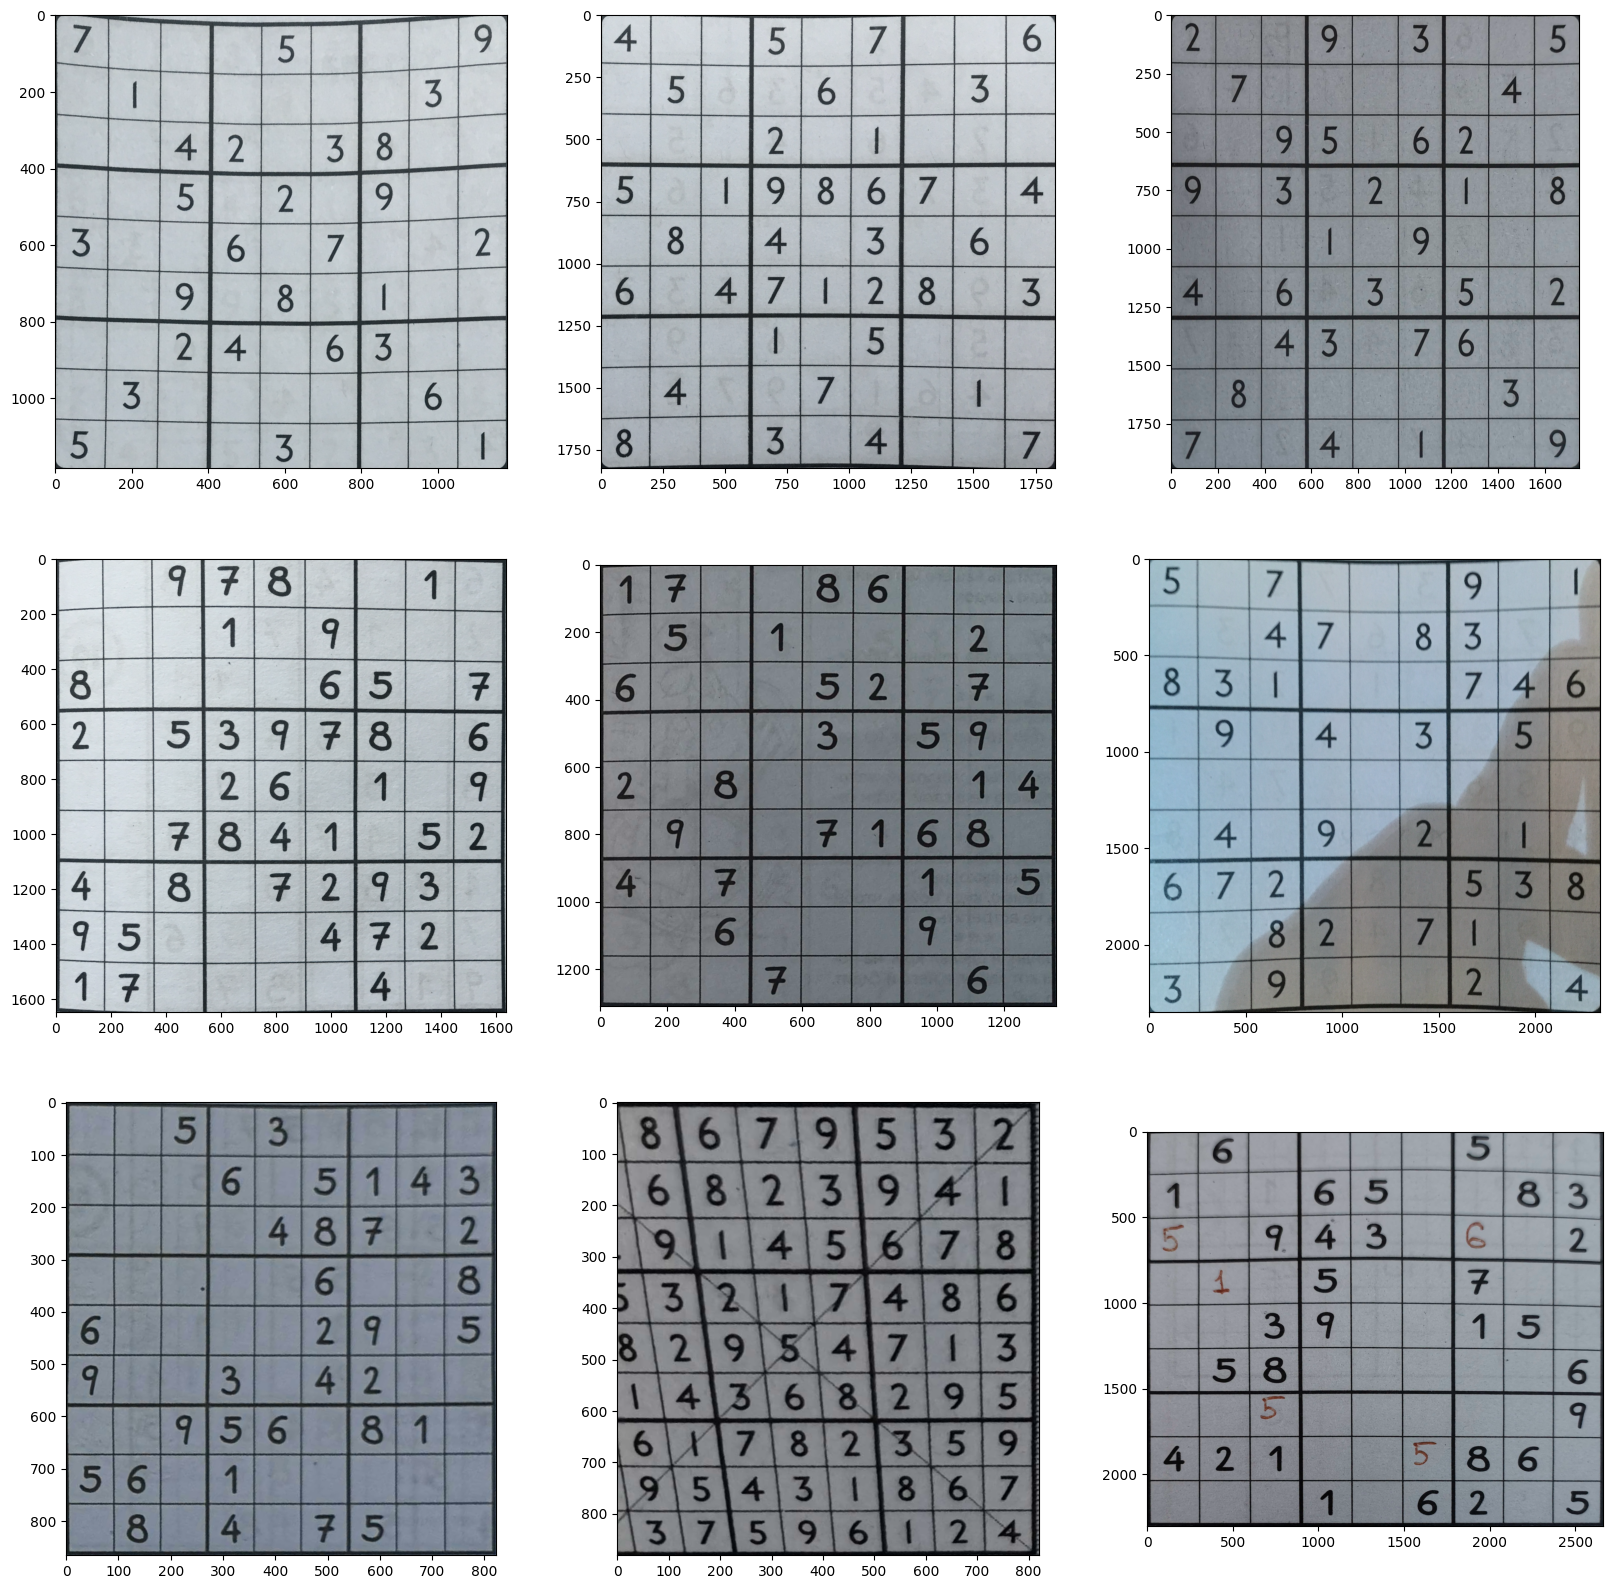

: 

In [17]:
fig,ax = plt.subplots(3,3, figsize=(20,20))
for i, fname in enumerate(TRAIN_IMG_NAMES):
    img = cv.imread(fname)
    puzzle, _ = find_puzzle(img)
    ax[i//3,i%3].imshow(puzzle);

In [ ]:
len(TRAIN_IMG_NAMES)

9